In [141]:
import numpy as np
import xarray as xr
import pandas as pd 
import datetime 

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline
%config inlinebackend.figure_format='retina'

In [21]:
# make functions we'll use 
# find index of value closest to desired value 
def find_nearest(desired, variable):
    diff = ([])
    for ll in variable:
        dd = np.absolute(desired - ll)
        diff.append(dd)
    ind = diff.index(min(diff))
    val = np.float(variable[ind])
    return ind

# convert hpa to km
# p = p0*exp(-z/H)
H = 10*1000 # km to m  
p0 = 100000 # Pa 
def hpa_to_km(hpa_in):
    m = np.log(hpa_in/p0)*-H
    km_out = m/1000
    return km_out

# and km to hpa 
def km_to_hpa(km_in):
    m = km_in*1000
    pa = p0*np.exp(-m/H)
    hpa_out = pa/100
    return hpa_out

In [255]:
# load in contrast rf11 file 
# https://drive.google.com/file/d/1xVarpVV6Su5ophCqOpG14D4lHrF1xHBa/view?usp=sharing
myurl_start = 'https://docs.google.com/uc?export=download&id='

! wget -O contrast_file 'https://docs.google.com/uc?export=download&id=1xVarpVV6Su5ophCqOpG14D4lHrF1xHBa'

/bin/sh: wget: command not found


In [35]:
# read in the file 
toga = xr.open_dataset('contrast_file')

# make a smaller more workable data set (we dont need all those variables)
toga = toga[['Time','GGLAT', 'GGLON', 'GGALT', 'DMS', 'Bromoform', 'CFC11']]

# clean up data, remove fill values 
toga.GGALT.where(toga.GGALT > 0)
toga.GGLON.where(toga.GGLON > 0)
toga.GGLAT.where(toga.GGLAT > 0)

toga.DMS.where(toga.DMS > 0)
toga.Bromoform.where(toga.Bromoform > 0)
toga.CFC11.where(toga.CFC11 > 0)

# units are pptv 

<xarray.DataArray 'CFC11' (Time: 196)>
array([224.8, 224.1, 223.8, 228. , 231. , 228. , 225.7, 229. , 225.1,
       227.6, 226.5, 233.8, 232.6, 231.5, 224.9, 225.3, 223. , 232.4,
       227.7, 228.2, 230.3, 229.5, 228.2, 221.1, 232.7, 231.1, 232.9,
       230. , 238.2, 233.2, 240.7, 239.3, 227.7, 230.7, 233.3, 231.8,
       233.4, 230. , 234.2, 235.9, 237.2, 238.9, 234.9, 238.9, 233.1,
       233.5, 233.2, 234.9, 235.8, 231.4, 245.1, 236.9, 245. , 240.3,
       236.9, 236.4, 242.2, 240.4, 238.9, 238. , 237.5, 237.1, 240.4,
       242.6, 240. , 236.6, 235.8, 239.9, 237.7, 239.5, 241.8, 244.7,
       240.4, 242. , 233.9, 242. , 241.5, 236.4, 238.8, 236.9, 244.4,
       237.3, 242.1, 242.8, 243.4, 244.3, 245.3, 245.6, 246.5, 239.4,
       243.1, 243.1, 240.7, 249.7, 244.2, 237.4, 242.7, 241.2, 244. ,
       250.8, 249.1, 246.6, 246.6, 245.6, 250.4, 245.4, 248.6, 243. ,
       246.1, 242.6, 238.7, 243.1, 246.7, 248. , 245.4, 241.8, 244.3,
       245.3, 245.9, 237.3, 245. , 246.4, 242.7, 25

In [257]:
# load in small camchem rf11 file 
# https://drive.google.com/file/d/1XnQLD3iAt6ALa1D8P1GMZTmK1317ZPE8/view?usp=sharing
myurl_start = 'https://docs.google.com/uc?export=download&id='

! wget -O camchem_file 'https://docs.google.com/uc?export=download&id=1XnQLD3iAt6ALa1D8P1GMZTmK1317ZPE8'

/bin/sh: wget: command not found


In [6]:
cam = xr.open_dataset('camchem_file')
cam = cam[['DMS', 'CHBR3', 'NO2']]*(1e12)
cam

<xarray.Dataset>
Dimensions:  (lat: 32, lev: 56, lon: 25, time: 1)
Coordinates:
  * time     (time) object 2014-12-01 00:00:00
  * lon      (lon) float64 130.0 131.2 132.5 133.8 ... 156.2 157.5 158.8 160.0
  * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 26.86 27.8 28.74 29.69
  * lev      (lev) float64 1.868 2.353 2.948 3.677 ... 947.5 962.5 977.5 992.5
Data variables:
    DMS      (time, lev, lat, lon) float32 4.1773454e-25 ... 14.167538
    CHBR3    (time, lev, lat, lon) float32 5.949005e-26 ... 1.6521943
    NO2      (time, lev, lat, lon) float32 6349.8174 6286.261 ... 71.89326
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             f.e11.TS1IREFC1SD.f09.f09.ccmi34.Aircraft_2014-2016.cy.001
    title:            UNSET
    logname:          dkin
    host:             r1i4n16
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade2/scratch2/dkin/f.e11.TS1IREFC1SD.f09.f09.ccmi34....
    topography_file:  /glade/p/acd

In [ ]:
###################### ORIENTATION ######################

Text(129, 14, 'Phillipines')

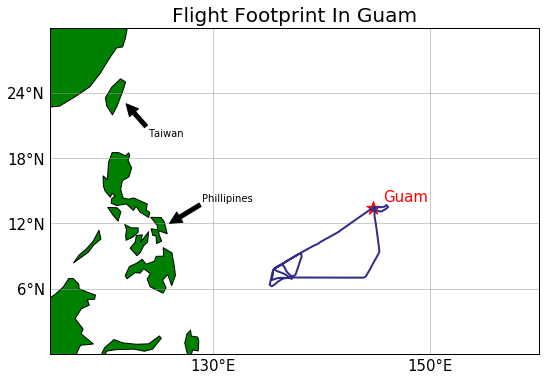

In [147]:
# ------------------------------------------- figure 0 -------------------------------------------
########## plot location 
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.plot(toga.GGLON, toga.GGLAT, c = [0.18, 0.18, 0.53], linewidth = 2)
ax.set_title('Flight Footprint In Guam', fontsize=20)

latmin = 0 
latmax = 30 
lonmin = 115 
lonmax = 160

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
#ax.coastlines(resolution='50m', color='k', linewidth=1)
ax.add_feature(cf.LAND, facecolor = 'g', edgecolor = 'k')
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([lonmin, 130, 150, lonmax])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# add guam marker 
plt.scatter(144.7, 13.4, s = 200, c = 'r', marker = '*')
ax.text(144.7+3, 13.4+1, "Guam", c = 'r', ha="center", va="center", size=15)

# add some arrows 
ax.annotate('Taiwan', xy=(122, 23),
             xytext=(124, 20), arrowprops={'facecolor': 'k'})
ax.annotate('Phillipines', xy=(126, 12),
             xytext=(129, 14), arrowprops={'facecolor': 'k'})

Text(147.7, 11.4, 'Guam')

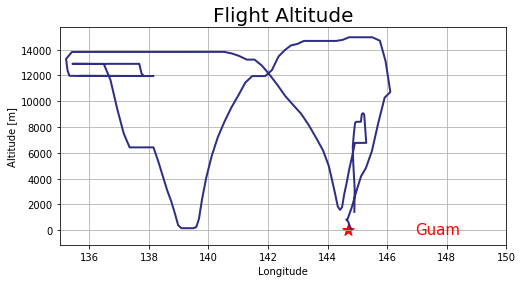

In [148]:
########## plot vertical
fig, ax = plt.subplots(figsize = (8, 4))

plt.plot(toga.GGLON, toga.GGALT, c = [0.18, 0.18, 0.53], linewidth = 2)
ax.set_title('Flight Altitude', fontsize=20)

ax.set_xlim([135, 150])
ax.set_xlabel('Longitude')
ax.set_ylabel('Altitude [m]')

ax.grid(which = 'major')

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'r', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'r', ha="center", va="center", size=15)

In [ ]:
###################### CONTRAST DATA ######################

Text(14, 142, 'Guam')

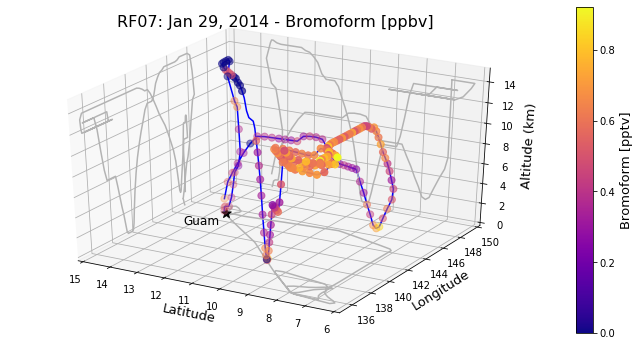

In [13]:
# ------------------------------------------- figure 1 -------------------------------------------
# Bromoform along flight track 
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# axis limits
maxx = toga.Bromoform.max()
minn = toga.Bromoform.min()

# plot 
ax.set_title('RF07: Jan 29, 2014 - Bromoform [ppbv]', fontsize = 16)
a = ax.plot(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c='b')
a = ax.scatter3D(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c=toga.Bromoform, 
                 s = 50, cmap='plasma', vmin = 0, vmax = maxx)
ax.set_xlabel('Latitude', fontsize = 13)
ax.set_xlim([15,6])
ax.set_ylabel('Longitude', fontsize = 13)
ax.set_ylim([135, 150])
ax.set_zlabel('Altitude (km)', fontsize = 13);
ax.set_zlim([0, 15])

# colorbar 
cbar = fig.colorbar(a)
cbar.set_label('Bromoform [pptv]', fontsize = 13)

# add gray lines 
flat1 = np.zeros_like(toga.GGALT/1000)
ax.plot3D(toga.GGLAT, toga.GGLON, flat1, c=[0.7, 0.7, 0.7])
flat2 = np.full_like(toga.GGLAT, 15)
ax.plot3D(flat2, toga.GGLON, toga.GGALT/1000, c=[0.7, 0.7, 0.7])
flat3 = np.full_like(toga.GGLON, 150)
ax.plot(toga.GGLAT, flat3, toga.GGALT/1000, c=[0.7, 0.7, 0.7])

# add guam pointer 
ax.scatter(13.4, 144.8, marker = '*', color = 'k', s = 100)
ax.text(14, 142, 0, s='Guam', fontsize=12)

Text(14, 142, 'Guam')

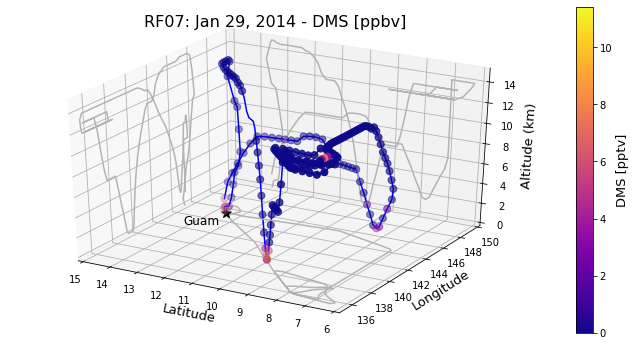

In [14]:
# ------------------------------------------- figure 2 -------------------------------------------
# DMS along flight track 
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# axis limits
maxx = toga.DMS.max()
minn = toga.DMS.min()

# plot 
ax.set_title('RF07: Jan 29, 2014 - DMS [ppbv]', fontsize = 16)
a = ax.plot(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c='b')
a = ax.scatter3D(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c=toga.DMS, 
                 s = 50, cmap='plasma', vmin = 0, vmax = maxx)
ax.set_xlabel('Latitude', fontsize = 13)
ax.set_xlim([15,6])
ax.set_ylabel('Longitude', fontsize = 13)
ax.set_ylim([135, 150])
ax.set_zlabel('Altitude (km)', fontsize = 13);
ax.set_zlim([0, 15])

# colorbar 
cbar = fig.colorbar(a)
cbar.set_label('DMS [pptv]', fontsize = 13)

# add gray lines 
flat1 = np.zeros_like(toga.GGALT/1000)
ax.plot3D(toga.GGLAT, toga.GGLON, flat1, c=[0.7, 0.7, 0.7])
flat2 = np.full_like(toga.GGLAT, 15)
ax.plot3D(flat2, toga.GGLON, toga.GGALT/1000, c=[0.7, 0.7, 0.7])
flat3 = np.full_like(toga.GGLON, 150)
ax.plot(toga.GGLAT, flat3, toga.GGALT/1000, c=[0.7, 0.7, 0.7])

# add guam pointer 
ax.scatter(13.4, 144.8, marker = '*', color = 'k', s = 100)
ax.text(14, 142, 0, s='Guam', fontsize=12)

In [10]:
###################### CAMCHEM DATA ######################

Text(147.7, 11.4, 'Guam')

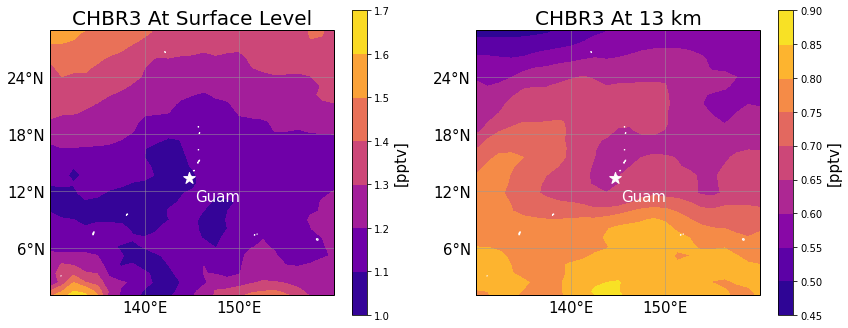

In [38]:
# ------------------------------------------- figure 3 -------------------------------------------
# plot camchem at surface level and at 11 km - CHBR3 
# test plot 
fig = plt.figure(figsize=(14, 8))

# ------------------------- Near Surface 
# surface
surf = find_nearest(km_to_hpa(1), cam['lev'])

# plot 
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
chbr3_surf = cam['CHBR3'].isel(lev = surf).squeeze()
plt.contourf(chbr3_surf.lon, chbr3_surf.lat, chbr3_surf, cmap = 'plasma')
ax.set_title('CHBR3 At Surface Level', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


# ------------------------- Near UT 
# 10 km
ut = find_nearest(km_to_hpa(13), cam['lev'])

# plot 
ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
chbr3_ut = cam['CHBR3'].isel(lev = ut).squeeze()
plt.contourf(chbr3_ut.lon, chbr3_ut.lat, chbr3_ut, cmap = 'plasma')
ax.set_title('CHBR3 At 13 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


Text(147.7, 11.4, 'Guam')

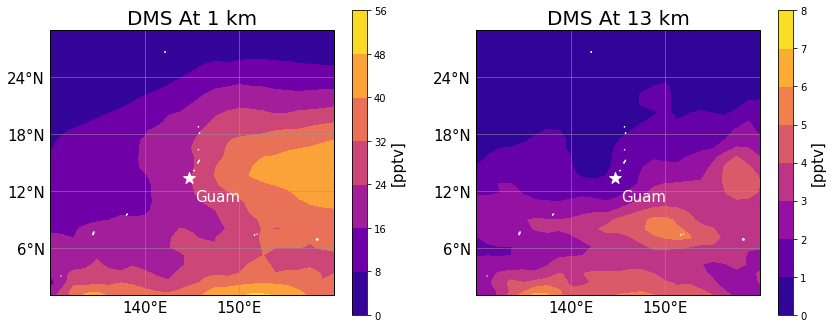

In [39]:
# ------------------------------------------- figure 4 -------------------------------------------
# plot camchem at surface level and at 11 km - DMS 
# test plot 
fig = plt.figure(figsize=(14, 8))

# ------------------------- Near Surface 
# surface
surf = find_nearest(km_to_hpa(1), cam['lev'])

# plot 
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
DMS_surf = cam['DMS'].isel(lev = surf).squeeze()
plt.contourf(DMS_surf.lon, DMS_surf.lat, DMS_surf, cmap = 'plasma')
ax.set_title('DMS At 1 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


# ------------------------- Near UT 
# 13 km 
ut = find_nearest(km_to_hpa(13), cam['lev'])

# plot 
ax = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
DMS_ut = cam['DMS'].isel(lev = ut).squeeze()
plt.contourf(DMS_ut.lon, DMS_ut.lat, DMS_ut, cmap = 'plasma')
ax.set_title('DMS At 13 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


In [27]:
###################### STATISTICAL COMPARISON ######################

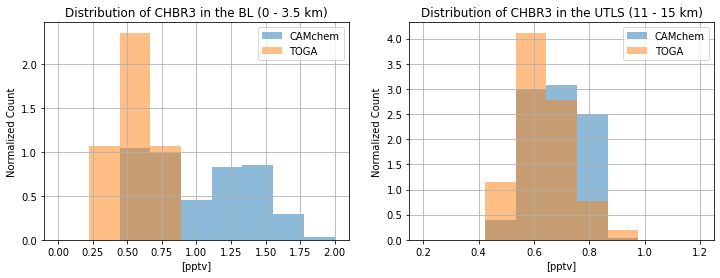

In [57]:
# ------------------------------------------- figure 5 -------------------------------------------
# CHBR3 comparison in boundary layer (BL) and upper troposphere lower stratosphere (UTLS) 

# ------------------------ BL 
# camchem values near surface 
bltop = km_to_hpa(3.5)
cam_chbr3_bl = cam['CHBR3'].sel(lev = slice(bltop,1000)).values.flatten()
# toga values near surface
toga_chbr3_bl = toga.Bromoform[np.where(toga.GGALT < 3500)]

# plot 
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

bins = np.linspace(0, 2, 10)
ax[0].hist(cam_chbr3_bl, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[0].hist(toga_chbr3_bl, bins, alpha=0.5, density = True, label = 'TOGA')

ax[0].grid(which = 'major')
ax[0].set_title ('Distribution of CHBR3 in the BL (0 - 3.5 km)')
ax[0].set_xlabel('[pptv]')
ax[0].set_ylabel('Normalized Count')
ax[0].legend()

# ------------------------ UT
uttop = km_to_hpa(15)
utbottom = km_to_hpa(11)
# camchem values in upper tropo 
cam_chbr3_ut = cam['CHBR3'].sel(lev = slice(uttop,utbottom)).values.flatten()
# toga values near surface
toga_chbr3_ut = toga.Bromoform[np.where(toga.GGALT > 11000)]

# plot 
bins = np.linspace(0.2, 1.2, 10)
ax[1].hist(cam_chbr3_ut, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[1].hist(toga_chbr3_ut, bins, alpha=0.5, density = True, label = 'TOGA')

ax[1].grid(which = 'major')
ax[1].set_title ('Distribution of CHBR3 in the UTLS (11 - 15 km)')
ax[1].set_xlabel('[pptv]')
ax[1].set_ylabel('Normalized Count')
ax[1].legend()

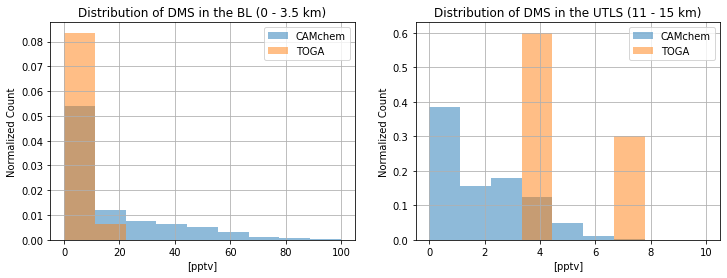

In [149]:
# ------------------------------------------- figure 6 -------------------------------------------
# DMS comparison in boundary layer (BL) and upper troposphere lower stratosphere (UTLS) 

# ------------------------ BL 
# camchem values near surface 
bltop = km_to_hpa(3.5)
cam_dms_bl = cam['DMS'].sel(lev = slice(bltop,1000)).values.flatten()
# toga values near surface
toga_dms_bl = toga.DMS[np.where(toga.GGALT < 3500)]

# plot 
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

bins = np.linspace(0, 100, 10)
ax[0].hist(cam_dms_bl, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[0].hist(toga_dms_bl, bins, alpha=0.5, density = True, label = 'TOGA')

ax[0].grid(which = 'major')
ax[0].set_title ('Distribution of DMS in the BL (0 - 3.5 km)')
ax[0].set_xlabel('[pptv]')
ax[0].set_ylabel('Normalized Count')
ax[0].legend()

# ------------------------ UT
uttop = km_to_hpa(15)
utbottom = km_to_hpa(11)
# camchem values in upper tropo 
cam_dms_ut = cam['DMS'].sel(lev = slice(uttop,utbottom)).values.flatten()
# toga values near surface
toga_dms_ut = toga.DMS[np.where(toga.GGALT > 11000)]

# plot 
bins = np.linspace(0, 10, 10)
ax[1].hist(cam_dms_ut, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[1].hist(toga_dms_ut, bins, alpha=0.5, density = True, label = 'TOGA')

ax[1].grid(which = 'major')
ax[1].set_title ('Distribution of DMS in the UTLS (11 - 15 km)')
ax[1].set_xlabel('[pptv]')
ax[1].set_ylabel('Normalized Count')
ax[1].legend()